# K-CAP Assignment

Below are the instructions for the assignment. Please read and follow them carefully.
1. There are 3 parts in this assignment, **none** of which are optional
2. Answer/code for each question is to be written in the code cell following the question
3. Do not add any additional includes. If there are any additional import statements in any form, we will not consider your submission.
4. **Do not edit this notebook**. Make a copy in your drive and solve the assignment
5. Comment your code wherever needed
6. The resources that may be required for help are uploaded on this [github repo](https://github.com/krittikaiitb/tutorials)
7. The deadline for this assignment submission is **6th December 2025**.
8. Upload the link to your .ipynb notebook on this [google form](https://docs.google.com/forms/d/e/1FAIpQLSclZjtsO0ZFgAJ0qF6vy-7kSIAu-aY6sPN2VvwuzXMe9AShvg/viewform?usp=publish-editor) for submission
9. Make sure you have given access to the submission file before submitting.

### All The Best!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Part 1: Orbital Simulation

As one has done in JEE times, we can express the a point on an ellipse in a parametric manner. If we consider a standard ellipse, of the form $ \frac{x^2}{a^2} + \frac{y^2}{b^2} = 1 $, we can parameterise it as $ (x,y) = (a \cos(E), b\sin(E)) $, where $E$ is called the "eccentric anomaly". We generally know $e$, the eccentricity of this ellipse and $a$, the semi-major axis.

While simulating orbits however, we would like to put the origin at the central body around which the lighter object orbits. This means that one needs to shift the origin. Let our central body be at the positive-X focus of the ellipse; $a\geq b$.

In the following code block, write code to convert $E$, $a$ and $e$ to a set of coordinates in the X-Y plane representing the point

In [7]:
a_earth = 1.496e11 # meters
e_earth = 0.0167

def coords_earth(E: float, a: float, e: float) -> np.ndarray[float]:
    # Firstly calculating the semi-minor axis length
    b = a*np.sqrt(1 - e**2)

    # Shifting positive X focus to origin
    X = a*(np.cos(E)-e)
    Y = b*np.sin(E)

    # Returning the coordinates of earth
    return np.array([X,Y])

# For example lets take value of E to be 0.7 and calculate the coordinate of earth
coords_earth(0.7,a_earth,e_earth)

array([1.11922071e+11, 9.63615261e+10])

The eccentric anomaly $E$ does not vary linearly with time $t$, but we define a quantity called the "mean anomaly" which does and is defined as $M = \frac{2\pi t}{T}$ where $T$ is the time period of the orbit. Using Kepler's third law, one can derive what is called Kepler's Equation: $$ M = E - e \cdot\sin(E) $$

This is a transendental equation and does not have "nice" solutions. Hence, we must resort to numerically solving it using the Newton-Raphson method. In the following code block, implement the Newton-Raphson method for Kepler's Equation.

In [14]:
def kepler_solver(M: float, e: float) -> float:

    # Assuming some tolerance and max iteration values
    tol = 1e-12
    max_iter = 50

    # Normalizing the Mean Anomaly to [-pi,pi] so that it can converge
    M0 = (M + np.pi) % (2 * np.pi) - np.pi

    # Series expansion of the inverse kepler equation
    E = M0 + e * np.sin(M0) + 0.5 * e**2 * np.sin(2 * M0)

    # Applying the loop to perform calculation for getting roots using the Newton-Raphson method
    for _ in range(max_iter):

        # Fuction value with some initial guess
        f = E - e * np.sin(E) - M0
        # Derivative function value
        fp = 1 - e * np.cos(E)

        # Taking care of the edge cases as if denominator becomes zero then the Newton-Raphson method would explode
        if abs(fp) < 1e-14:
            E += 1e-6
            fp = 1 - e * np.cos(E)

        # Calculate the division value of f and fp
        delta = f / fp
        E -= delta

        if abs(delta) < tol and abs(f) < tol:
            break

    k = int(np.round((M - M0) / (2 * np.pi)))
    E += 2 * np.pi * k

    return float(E)

# Taking M equal to 1 and getting the value of E
kepler_solver(1,e_earth)

1.0141790871647136

Once we can convert $M$ to $E$ and $E$ to coordinates, one can simply plot the points using plt.scatter to find the orbits. Do so in the following code block

In [15]:
T_earth = 365.2422 # days

def plot_orbit(a: float, e: float, T: float):
    M_vals = np.arange(0, T, 1) * 2 * np.pi / T  # one dot per day

    Xs = []
    Ys = []
    for M in M_vals:
        E = kepler_solver(M, e)
        x, y = coords_earth(E, a, e)
        Xs.append(x)
        Ys.append(y)

    plt.figure(figsize=(6, 6))
    plt.scatter(Xs, Ys, s=6, marker='o', linewidths=0)
    # mark the central body (at origin since coords_earth shifts focus there)
    plt.scatter([0], [0], color='k', s=36, marker='x', label='central body')
    plt.gca().set_aspect('equal', 'box')
    plt.title(f"Orbit (a={a:.3e} m, e={e})")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.legend()
    plt.show()

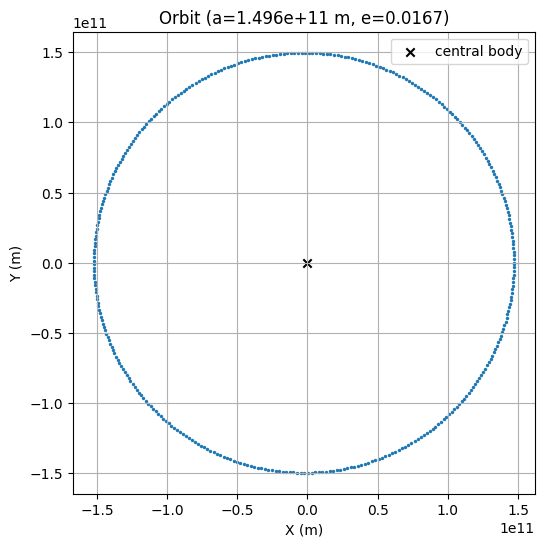

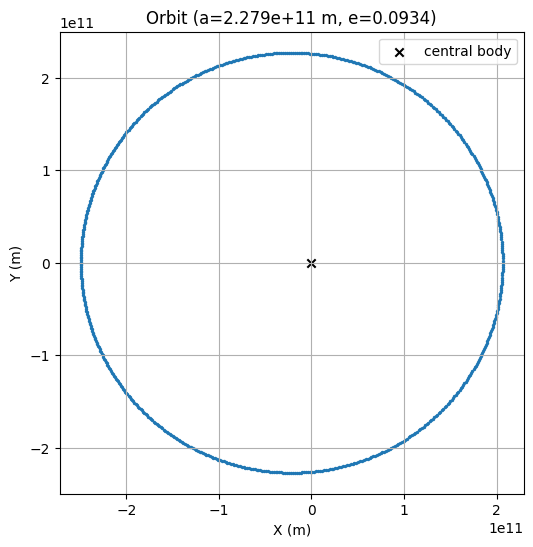

In [16]:
# show plots of the orbits:

plot_orbit(a_earth, e_earth, T_earth) # orbit of earth

plot_orbit(2.279e11, 0.0934, 687.0) # orbit of mars

## Part 2: Cosmic Expansion

Einstein's General Relativity predicts that the universe expands and contracts based on the energy content of the universe. This energy can come in several forms, such as
1. Mass - captured in the mass density parameter $\Omega_m$
2. Radiation - captured in the radiation density parameter $\Omega_r$
3. Curvature of space - captured in its effective density parameter $\Omega_\kappa$
4. Dark energy - captured in its effective density parameter $\Omega_\Lambda$

We define a scale factor $a(t)$ which shows how large or small the universe has become. In particular, if an object is at a distance $R_0$ today, it is at a distance of $R_0 \cdot a(t)$ at time $t$

The expansion of the universe is governed by the Friedmann Equation. We will, in particular, consider the first of the two:

$$\left( \frac{\dot{a}}{a} \right)^2 = H_0^2 \left( \Omega_{r,0} a^{-4} + \Omega_{m,0} a^{-3} + \Omega_{\kappa,0} a^{-2} + \Omega_{\Lambda,0} \right)$$

Where $H_0$ is the value of $\left( \frac{\dot{a}}{a} \right)$ at present time and is called as "Hubble's Constant"

Your task is to solve this ODE to find a(t), set up with $t=0$ is the present day and $a(0) = 1$.

In [17]:
Omega_r0 = 1e-5
Omega_m0 = 0.353
Omega_kappa0 = 0 # within errors of experiment, we see an almost flat universe irl!
Omega_Lambda = 0.647

H0_hubble = 70  # in units of km/s/MPc - used in this form for hubble's law
H0_s = 2.27e-18 # in units of 1/s      - convenient form 1 for plotting
H0_y = 7.14e-11 # in units of 1/year   - convenient form 2 for plotting

H0 = H0_y # choose one of the above to plot

# Time array (units based on choise of H0)
t_eval = np.linspace(-1, 1, 201) / H0

In [18]:
def a_dot(t, a):
    a = float(a)

    # Avoiding division by zero / negative scale factors
    if a <= 0.0:
        return 0.0
    
    term_r = Omega_r0 * a**(-4)
    term_m = Omega_m0 * a**(-3)
    term_k = Omega_kappa0 * a**(-2)
    term_L = Omega_Lambda

    inside = term_r + term_m + term_k + term_L

    if inside < 0 and inside > -1e-16:
        inside = 0.0

    H = H0 * np.sqrt(inside)
    return a*H

sol = solve_ivp(a_dot, (t_eval[0], t_eval[-1]), [1.0], t_eval=t_eval)

C:\Users\JAYENT DEV\AppData\Local\Temp\ipykernel_24784\3092954263.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = float(a)


In [19]:
def plot_a():

    # Solving the ODE: da/dt = a_dot(t, a)
    sol = solve_ivp(
        a_dot,
        (t_eval[0], t_eval[-1]),
        [1.0],
        t_eval=t_eval,
        method='RK45',
        rtol=1e-9,
        atol=1e-12
    )

    # Extracting the solution
    a_vals = sol.y[0]

    # Ploting the result
    plt.figure(figsize=(8,5))
    plt.plot(t_eval * H0, a_vals, label="a(t)")
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    plt.title("Scale Factor Evolution from Friedmann Equation")
    plt.xlabel(r"Time $t$ (units of $1/H_0$)")
    plt.ylabel(r"Scale factor $a(t)$")
    plt.grid(True)
    plt.legend()
    plt.show()


C:\Users\JAYENT DEV\AppData\Local\Temp\ipykernel_24784\3092954263.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = float(a)


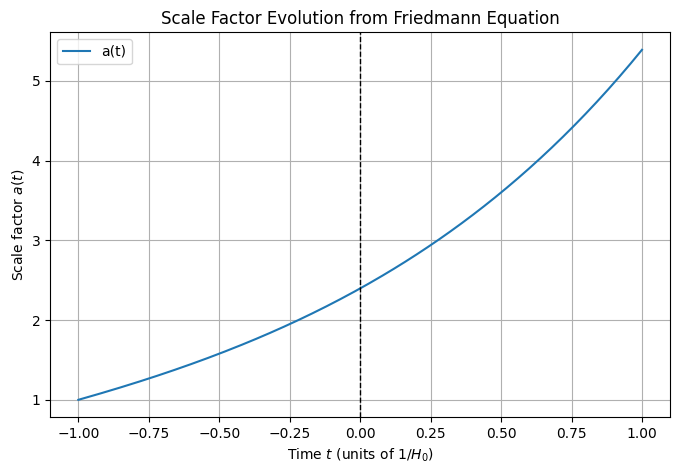

In [20]:
plot_a() # plot the function a(t)

## Part 3: The Solar Analemma

The Analemma is the figure-8 shape traced by the Sun in the sky if observed at the same "time" (technically: Mean Solar Time) every day. It arises from the interaction between Earth's orbital eccentricity and its axial tilt.

We are now working in 3D instead of 2D, so we need to change the vectors to use 3D instead. Using the same method as in part 1, give the coordinates of the sun as seen from earth, putting the orbit in the X-Y plane and the perihelion of earth in the positive Y-axis.

In [21]:
def coords_3d(M: np.ndarray[float], a: float, e: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    # Firstly converting M to E using kepler_solver elementwise
    E = np.array([kepler_solver(Mi, e) for Mi in M])

    # Semi-minor axis
    b = a * np.sqrt(1 - e**2)

    # Standard ellipse (perihelion at +X)
    X = a * (np.cos(E) - e)
    Y = b * np.sin(E)

    # Rotate by +90 degrees so perihelion lies on +Y
    # x = -Y,   y = X
    x = -Y
    y = X

    # Orbit is planar
    z = np.zeros_like(x)

    return x, y, z

The axis of the earth is tilted by $\epsilon = 23.44^\circ$ with respect to the orbit of the earth. We would like to rotate about say the Y-axis to do this, but for that, the perihelion is at the wrong position. It is known that the "longitude of the perihelion" is $\varpi = 282.895^\circ$, i.e. the closest point is positioned at an angle of $\varpi$ counter-clockwise of the Y-axis in our picture. Write code to rotate the orbit to get the correct position of the perihelion:

In [22]:
longitude_of_perihelion = 282.895 # degrees

def rotate_perihelion(x: np.ndarray, y: np.ndarray, z: np.ndarray, longitude_of_perihelion: float):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)

    phi = np.deg2rad(longitude_of_perihelion)

    c = np.cos(phi)
    s = np.sin(phi)

    x_rot = c * x - s * y
    y_rot = s * x + c * y
    z_rot = z.copy() 

    return x_rot, y_rot, z_rot

Now, we want to rotate about the Y-axis to ensure that we have accounted for the tilt correctly. We want the points in the positive X-axis to also have positive z coordinates. Rotate by an angle of $\epsilon$ along the Y-axis to achieve this in code:

In [23]:
axial_tilt = 23.44 # degrees

def rotate_axial_tilt(x: np.ndarray, y: np.ndarray, z: np.ndarray, axial_tilt: float):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)

    eps = np.deg2rad(axial_tilt)

    c = np.cos(eps)
    s = np.sin(eps)

    x_rot =  c * x - s * z
    y_rot =  y
    z_rot =  s * x + c * z

    return x_rot, y_rot, z_rot

What we have now is the position of the sun as seen by an observer who does not rotate along with the earth. When we take pictures every solar day, we effectively have moved an angle of $M$ - the mean anamoly - in that time, as we would have faced the sun exactly if there were no axial tilt and if it were circular. We need to rotate back by an angle of $M$ in the X-Y plane to achieve this:

In [24]:
def rotate_mean_motion(x: np.ndarray, y: np.ndarray, z: np.ndarray, M: np.ndarray):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    M = np.asarray(M)

    c = np.cos(M)
    s = np.sin(M)

    x_rot = c * x + s * y
    y_rot = -s * x + c * y
    z_rot = z.copy()

    return x_rot, y_rot, z_rot

Now, we can plot the result to find our analemma:

In [27]:
# dont change this function
def plot_analemma(T: float, a: float, e: float, longitude_of_perihelion: float, axial_tilt: float):
    M = np.arange(0, T, 1) # one dot per day
    x1, y1, z1 = coords_3d(M, a, e)
    x2, y2, z2 = rotate_perihelion(x1, y1, z1, longitude_of_perihelion)
    x3, y3, z3 = rotate_axial_tilt(x2, y2, z2, axial_tilt)
    x, y, z = rotate_mean_motion(x3, y3, z3, M)
    norms = np.sqrt(x**2 + y**2 + z**2) / 1.05 # make vectors slightly larger to get blocked by the sphere

    # normalise the vectors
    x /= norms
    y /= norms
    z /= norms

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(x, y, z, label='Analemma', color='#ffc080', s=0.1)

    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='#808080', alpha=0.1, linewidth=0)

    ax.set_title("The Solar Analemma")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.axis('equal')
    ax.legend()

    plt.show()

In [28]:
%matplotlib widget
plot_analemma(T_earth, a_earth, e_earth, longitude_of_perihelion, axial_tilt)

RuntimeError: 'widget' is not a recognised GUI loop or backend name

What you have created is the shape of the analemma. This shape is visible through photographs if we take pictures at an interval of 24 hours in a fixed angle. The exact orientation of the shape depends on where and when exactly it is taken but the shape will be the same!